## Denoising Diffusion Probabilistic Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob

### Set model parameters

In [3]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

### Load dataset and train model

In [4]:
# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [28]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

In [29]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    # devices=4,
    # accelerator="cpu",
    # resume_from_checkpoint=last_checkpoint, 
    logger=tb_logger
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
# Train model
trainer.fit(model, train_loader, val_loader)


   | Name          | Type           | Params
--------------------------------------------------
0  | inc           | DoubleConv     | 37.7 K
1  | down1         | Down           | 295 K 
2  | down2         | Down           | 1.2 M 
3  | down3         | Down           | 2.4 M 
4  | up1           | Up             | 6.2 M 
5  | up2           | Up             | 1.5 M 
6  | up3           | Up             | 406 K 
7  | outc          | OutConv        | 65    
8  | sa1           | SAWrapper      | 395 K 
9  | sa2           | SAWrapper      | 395 K 
10 | sa3           | SAWrapper      | 99.6 K
11 | label_layer_1 | ExpandingLayer | 720 K 
12 | label_layer_2 | ExpandingLayer | 360 K 
13 | label_layer_3 | ExpandingLayer | 180 K 
14 | label_layer_4 | ExpandingLayer | 45.1 K
--------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.903    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

### Sample from model

In [43]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10
labels = torch.Tensor(list(range(9))).long()
# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t, labels)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

In [45]:
gen_samples

tensor([[[[  0],
          [  0],
          [255],
          ...,
          [ 98],
          [188],
          [  0]],

         [[  0],
          [  8],
          [255],
          ...,
          [  0],
          [123],
          [198]],

         [[  0],
          [178],
          [177],
          ...,
          [ 26],
          [115],
          [  0]],

         ...,

         [[  0],
          [ 69],
          [ 56],
          ...,
          [255],
          [ 91],
          [  0]],

         [[255],
          [255],
          [  0],
          ...,
          [ 16],
          [154],
          [255]],

         [[255],
          [ 74],
          [ 80],
          ...,
          [  0],
          [255],
          [255]]],


        [[[147],
          [  0],
          [255],
          ...,
          [ 98],
          [ 98],
          [  0]],

         [[  0],
          [  0],
          [112],
          ...,
          [ 31],
          [191],
          [255]],

         [[  4],
          [ 66

In [44]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    list(gen_samples),
    fps=5,
)

TypeError: Cannot handle this data type: (1, 1, 1), |u1

In [14]:
c = torch.Tensor(range(10))

torch.bernoulli(torch.zeros_like(c)+0.3)

tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])

In [123]:
torch.bernoulli(torch.zeros_like(c)+0.2)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [140]:
c.copy().bernoulli_(0.3)

AttributeError: 'Tensor' object has no attribute 'copy'

In [31]:
import numpy as np
z = torch.from_numpy(np.random.binomial(1,0.2,10))

In [17]:
c.to(c.device)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [29]:
import torch.nn as nn
c = c.long()

In [36]:
c = nn.functional.one_hot(c, num_classes=10).type(torch.float)

In [35]:
c

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
z.repeat(1,10)

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0]])

In [37]:
c

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [42]:
z[:, None].repeat(1,10)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [47]:
def gen_sampels(gif_shape = [3, 3], seed=777):
    torch.manual_seed(seed)
    sample_batch_size = gif_shape[0] * gif_shape[1]
    n_hold_final = 10
    labels = torch.Tensor(list(range(9))).long()

    # Generate samples from denoising process
    gen_samples = []
    x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in sample_steps:
        x = model.denoise_sample(x, t, labels)
        if t % 50 == 0:
            gen_samples.append(x)
    for _ in range(n_hold_final):
        gen_samples.append(x)
    gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
    gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2
    return gen_samples

In [48]:
# Process samples and save as gif
def gen_sampels_prepare(gen_samples):
    gen_samples = (gen_samples * 255).type(torch.uint8)
    gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

    def stack_samples(gen_samples, stack_dim):
        gen_samples = list(torch.split(gen_samples, 1, dim=1))
        for i in range(len(gen_samples)):
            gen_samples[i] = gen_samples[i].squeeze(1)
        return torch.cat(gen_samples, dim=stack_dim)
    gen_samples = stack_samples(gen_samples, 2)
    gen_samples = stack_samples(gen_samples, 2)
    return gen_samples

In [49]:
gen_samples = gen_sampels(seed=777)
gen_samples = gen_sampels_prepare(gen_samples)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [52]:
imageio.mimsave(
    f"pred.gif",
    [Image.fromarray(image.moveaxis(2, 0)[0].numpy().astype(np.uint8)) for image in gen_samples],
    fps=5,
)

def plot_generate(gen_samples):
    plt.figure()
    f, axarr = plt.subplots(2,2,  figsize=(15, 15)) 
    axarr[0,0].imshow(gen_samples[0,:].moveaxis(2, 0)[0])
    axarr[0,1].imshow(gen_samples[10,:].moveaxis(2, 0)[0])
    axarr[1,0].imshow(gen_samples[20,:].moveaxis(2, 0)[0])
    axarr[1,1].imshow(gen_samples[-1,:].moveaxis(2, 0)[0])

<Figure size 640x480 with 0 Axes>

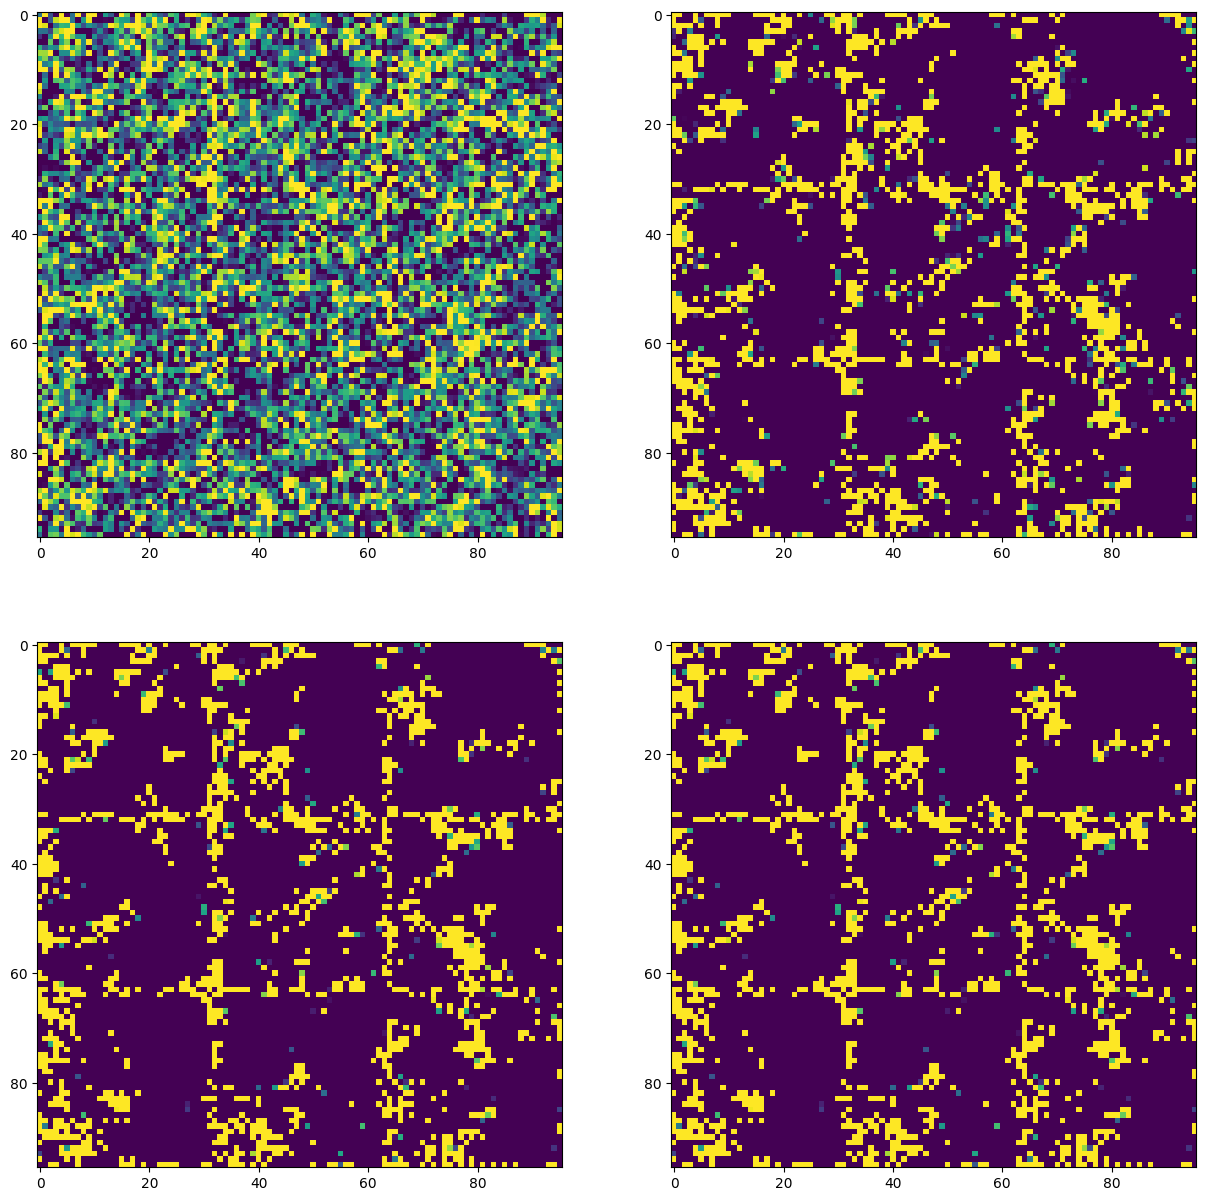

In [53]:
plot_generate(gen_samples)